# Exercise 5: Feature Extraction and Matching

In this exercise, you will learn:

- How to find key points in images and describe their features
- How to match key points between two views of the same scene

For some functions we already provide some draft implementation that you just need to complete. This is supposed to help you identifying the next steps.


## 0. Setup

Load all libraries and both views that we will work with.

In [1]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from PIL import Image
from scipy import signal

View 1 resolution: 449x600
View 2 resolution: 449x600


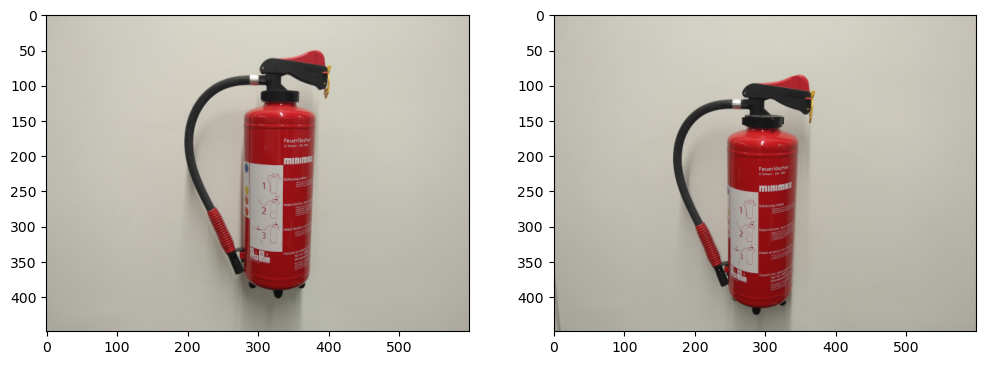

In [2]:
# Load images and resize
view1 = np.array(Image.open("data/exercise3/view1.png")) / 255
view2 = np.array(Image.open("data/exercise3/view2.png")) / 255

# Check resolution
print(f"View 1 resolution: {view1.shape[0]}x{view1.shape[1]}")
print(f"View 2 resolution: {view2.shape[0]}x{view2.shape[1]}")

# Show both views
_, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].imshow(view1)
axes[1].imshow(view2)
plt.show()

## 1. Key Point Detection and Feature Extraction

You might want to look again into the concepts explained in slide decks "04_sparse_geometry_1_appearance_matching.pdf" and "03_image_processing_2.pdf

In this part of the exercise, you will learn how to build your own key point detector and feature descriptor. Generally, you should rather use the implementation of traditional and well-known feature descriptors such as [SIFT](https://link.springer.com/article/10.1023/B:VISI.0000029664.99615.94), [ORB](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6126544), etc. But here, we will learn how to come up with our own method from scratch.

As a reminder: Feature extraction consists of two step. First, there is detection/localization of key points. Second, computing a feature vector for each key point to uniquely describe it.

### 1.1. Key Point Detection using Harris Corner Detector

Complete the implementation below. First you have to implement some helper functions (```smooth_image```, ```image_gradient```, ```compute_structure_tensor_Q```, ```compute_harris_score```, ```non_maximum_suppression```, ```compute_angles```). Finally you detect keypoints by implementing the function ```detect_corner_keypoints``` (and call your implemented helper functions from there). It is supposed to be a function that takes an image and some hyperparameters as inputs and returns a list of coordinates describing the location of detected key points. Furthermore, the orientation of the key point shall be returned. For key point detection you should apply the Harris detector to the image as dicussed in the lecture. For key point orientation, you should return the angle of the local gradient at each detected key point. The angle is important so that corresponding key points from differently rotated view points can be aligned. Hint: Use np.arctan2(x,y) for angle computation to get full 360 degree orientation.

In [3]:
# this time you may utilize library implementations of
# the image processing filters you learned about
from scipy.ndimage import sobel, gaussian_filter, maximum_filter, convolve 

def to_grayscale(img: npt.ArrayLike) -> np.ndarray:
    channel_weights = [0.299, 0.587, 0.114]
    weighted_img = img * np.reshape(channel_weights, (1,1,3))
    return np.sum(weighted_img, axis=2)

def smooth_image(image: npt.ArrayLike, sigma: int) -> np.ndarray:
    """Smooth the image with a gaussian filter"""
    # TODO: implement it
    return gaussian_filter(image, sigma=sigma)
    

def image_gradient(image: npt.ArrayLike, axis: int) -> np.ndarray:
    """Compute the image gradients with the sobel filter along the specified axis.

    :param image: grayscale image
    :param axis: specified axis
    :return array with the image gradient along specified axis
    """
    # TODO: implement it
    return sobel(image, axis=axis)

def compute_structure_tensor_Q(Ix: npt.ArrayLike, Iy: npt.ArrayLike, window_size: int) -> np.ndarray:
    """Compute the structure tensor Q.

    :param Ix: horizontal image gradient
    :param Iy: vertical image gradient
    :param window_size: window size for calculation
    :return array with structure tensor Q
    """
    # TODO: implement it
    Ix2 = Ix * Ix
    Iy2 = Iy * Iy
    Ixy = Ix * Iy
    kernel = np.ones((window_size, window_size))
    Q11 = convolve(Ix2, kernel)
    Q22 = convolve(Iy2, kernel)
    Q12 = convolve(Ixy, kernel)
    Q = np.stack((Q11, Q12, Q12, Q22), axis=2)
    return Q

def compute_harris_score(Q: npt.ArrayLike, k: float) -> np.ndarray:
    """Compute the harris score.

    :param Q: structure tensor
    :param k: hyperparameter
    :return array with harris scores
    """
    # TODO: implement it
    Q11 = Q[:,:,0]
    Q12 = Q[:,:,1]
    Q22 = Q[:,:,3]
    det = Q11 * Q22 - Q12 * Q12
    trace = Q11 + Q22
    return det - k * trace * trace

def non_maximum_suppression(H: npt.ArrayLike, threshold: int) -> np.ndarray:
    """Non-maximum surpression.

    :param H: Harris scores
    :param threshold: H > threshold -> pixel is corner candidate
    :return array keypoints as boolean mask
    """
    # TODO: implement it
    H_max = maximum_filter(H, size=5)# this roughly corresponds to r=2
    keypoint_mask = (H == H_max) & (H > threshold)
    return keypoint_mask

def compute_angles(Ix: npt.ArrayLike, Iy: npt.ArrayLike, keypoint_mask: npt.ArrayLike) -> np.ndarray:
    """Compute the angles of the keypoints.

    :param Ix: horizontal image gradient
    :param Iy: vertical image gradient
    :param keypoint_mask: array with the detected keypoints
    :return array containing the angle for each keypoint
    """
    # TODO: implement it
    Ix = Ix[keypoint_mask]
    Iy = Iy[keypoint_mask]
    return np.rad2deg(np.arctan2(Iy, Ix))
    
def detect_corner_keypoints(img, window_size=5, k=0.05, threshold=10):
    """
    This function takes an input image and computes harris corner locations and orientations
    :param img: the image
    :param window_size: size of the window in which we look for corners
    :param k: factor to compute the harris score, usually between 0.04 and 0.06
    :param threshold: Harris scores below this threshold are not considered
    :return: a tuple where the first element is a 2D numpy array of keypoint coordinate pairs
             and the second element is a numpy array of local gradient angle
    """
    # 1. convert to grayscale (use the already implemented function above)
    # TODO: implement it
    img = to_grayscale(img)
    
    # 2. smooth the image (implement the function above and call it)
    # TODO: implement it
    img = smooth_image(img, 1)
    
    # 3. compute image gradients in x and y direction (implement the function above and call it)
    # TODO: implement it
    Ix = image_gradient(img, 0)
    Iy = image_gradient(img, 1)
    
    # 4. compute structure tensor Q (implement the function above and call it)
    # TODO: implement it
    Q = compute_structure_tensor_Q(Ix, Iy, window_size)
    
    # 5. compute harris score (implement the function above and call it)
    # TODO: implement it
    H = compute_harris_score(Q, k)
    
    # 6. perform non-maximum surpression (implement the function above and call it)
    # TODO: implement it
    keypoint_mask = non_maximum_suppression(H, threshold)
    
    # 7. compute angles (implement the function above and call it)
    # TODO: implement it
    angles = compute_angles(Ix, Iy, keypoint_mask)
    
    # 8. return list containing pairs of coordinates
    # TODO: implement it
    keypoints = np.argwhere(keypoint_mask)[:, [1,0]]
    
    return keypoints, angles

Now compute the key points and visualize the corners you detected...

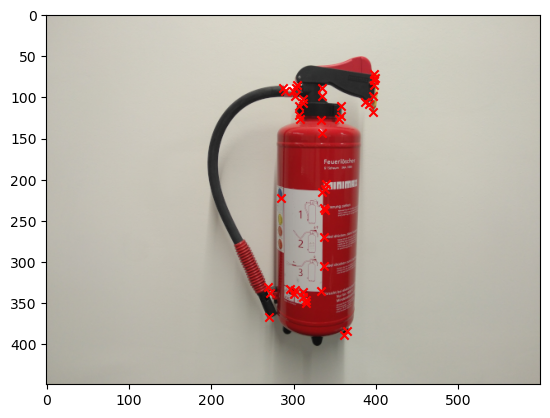

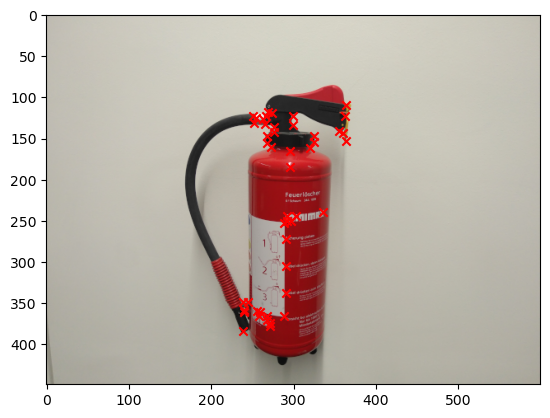

In [4]:
def plot_keypoints(img, points):
    plt.imshow(img)
    plt.scatter(points[:,0], points[:,1], marker='x', color='r')
    plt.show()


keypoints = {}
for i, target_image in  enumerate([view1, view2]):
    points, angles = detect_corner_keypoints(target_image, window_size=5, threshold=10)
    keypoints[f"view{i+1}"] = (points, angles)
    plot_keypoints(target_image, points)

If you did everything correctly you should already be able to spot some key points that correspond to the same real point in both views. Sofar the key points are robust in terms of rotation and translation. To become more robust against changes in scale, we would need to further extend our implementation. However this not in the scope of the exercise. But here is a sketch of the idea:

To achieve scale invariance we will detect corner key points at multiple scales of the input image. First, we will create a Gaussian pyramid of the image, i.e, we will blur the image and subsample by a factor of 2. We continue doing so until the image reaches a limit, say 32x32 pixels... Then, we will compute key points for each scale image and determine their location with respect to the original resolution. Afterwards, we supress duplicates.

### 1.2 Select patches around key points
 
Right now, we are aware of the keypoints in the image. However, we would like to have a unique description of every keypoint to rediscover it also in other views of the same scene. Therefore, we need to take a look at the proximity of the key point and encode the information we find there. We choose a patch of size 16x16 around each key point to extract information and transform them into a descriptor. The patches are rotated according to the key point orientation.

First, use the following plotting function to visulize the patches.

In [5]:
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D

def plot_patches(img, keypoints, angles):
    """
    :param img: image
    :param keypoints: Numpy array containig the keypoints
    :param rotations: Numpy array of length=len(keypoints) containing
                      the patch rotation
    """
    scales = np.ones(len(keypoints))*16    
    ax = plt.gca()
    ax.imshow(img)
    ax.scatter(points[:,0], points[:,1], marker='.', alpha=0.7, color='r')
    for kp, angle, length in zip(keypoints, angles, scales):
        rect = patches.Rectangle(kp - length / 2, length, length, linewidth=1,
                                 edgecolor='r', facecolor='none')
        transform = Affine2D().rotate_deg_around(*kp, angle) + ax.transData
        rect.set_transform(transform)
        ax.add_patch(rect)
        
    plt.show()

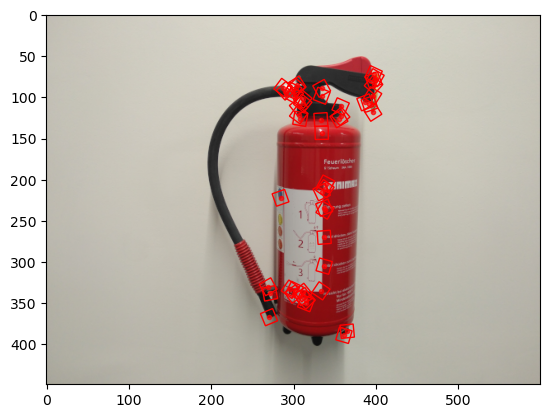

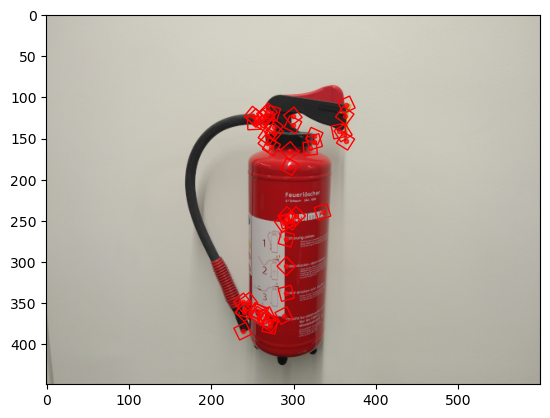

In [6]:
for i, target_image in  enumerate([view1, view2]):
    points, angles = keypoints[f"view{i+1}"]
    plot_patches(target_image, points, angles)

Now, complete the function that extracts the patches from a given view and returns them as 16x16 grayscale numpy arrays. Obviously, the array of patches shall have the same ordering as the key points. You may use `skimage.transform.rotate` to rotate the image before extracting the patches. Also, cropping the image before rotating will speed up your runtime.

Hint: You can pad the image using `np.pad` if the patches are extracted add the borders

In [7]:
from skimage.transform import rotate

def extract_patches(img, keypoints, angles, patch_size=16):
    """
    This function extracts oriented patches around the detected key points and returns
    them as grayscale images
    :param img: the input image
    :param keypoints: the extracted keypoints
    :param angles: the orientation of the keypoints
    :param patch_size: the pixel length of each patch in x,y directions
    :return: a 3D Numpy array containing all grayscale patches. The first dimension
             is the number of key points/patches. The second and third is 'patch_size'.
             
    """
    # first convert to grayscale
    if len(img.shape) == 3:
        monochrome_img = to_grayscale(img)
    else:
        monochrome_img = img
    
    # TODO: add padding such that also patches at the borders can be extracted
    pad_size = patch_size // 2
    padded_img = np.pad(monochrome_img, pad_size)
    
    # TODO: extract patches
    patches = []
    for (x, y), angle in zip(keypoints, angles):
        patch = padded_img[y:y+patch_size, x:x+patch_size]
        patch = rotate(patch, angle)
        patches.append(patch)

    return np.stack(patches)

In [8]:
patches_view1 = extract_patches(view1, *keypoints["view1"])
patches_view2 = extract_patches(view2, *keypoints["view2"])

In [9]:
def plot_patch_crops(patches):
    # define image grind
    cols = 10
    rows = int(np.ceil(len(patches) / cols))
    
    # create subplots
    _, axes = plt.subplots(rows, cols, figsize=(16, rows * 3 ))
    axes = axes.flatten()
    for patch, ax in zip(patches,axes):
        ax.imshow(patch)
    plt.show()

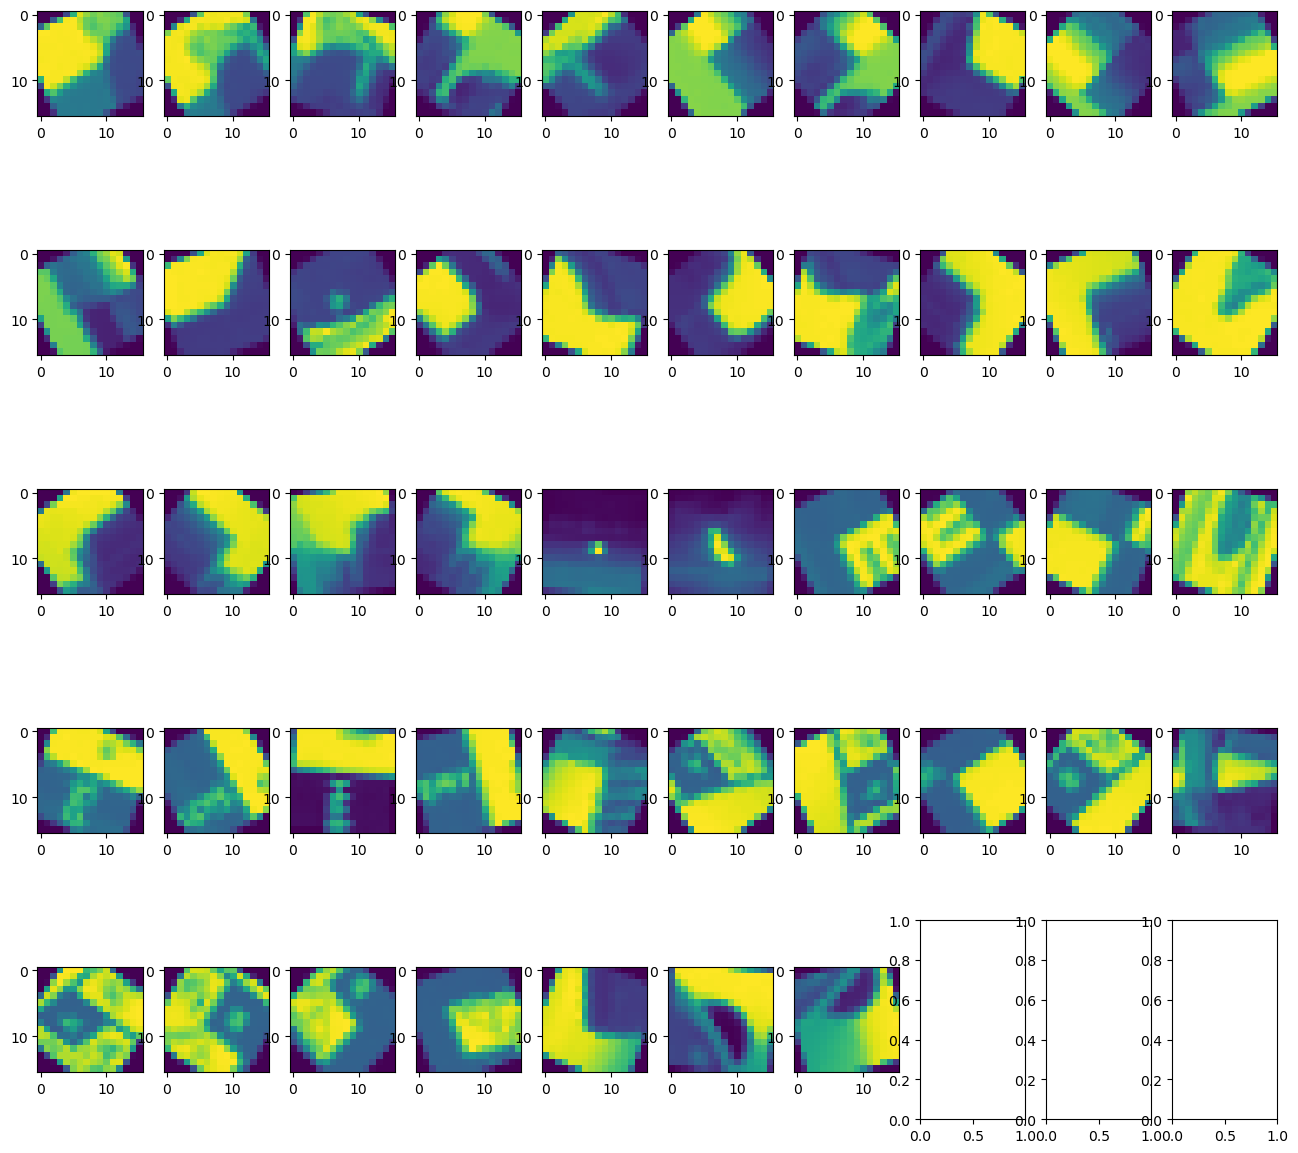

In [10]:
plot_patch_crops(patches_view1)

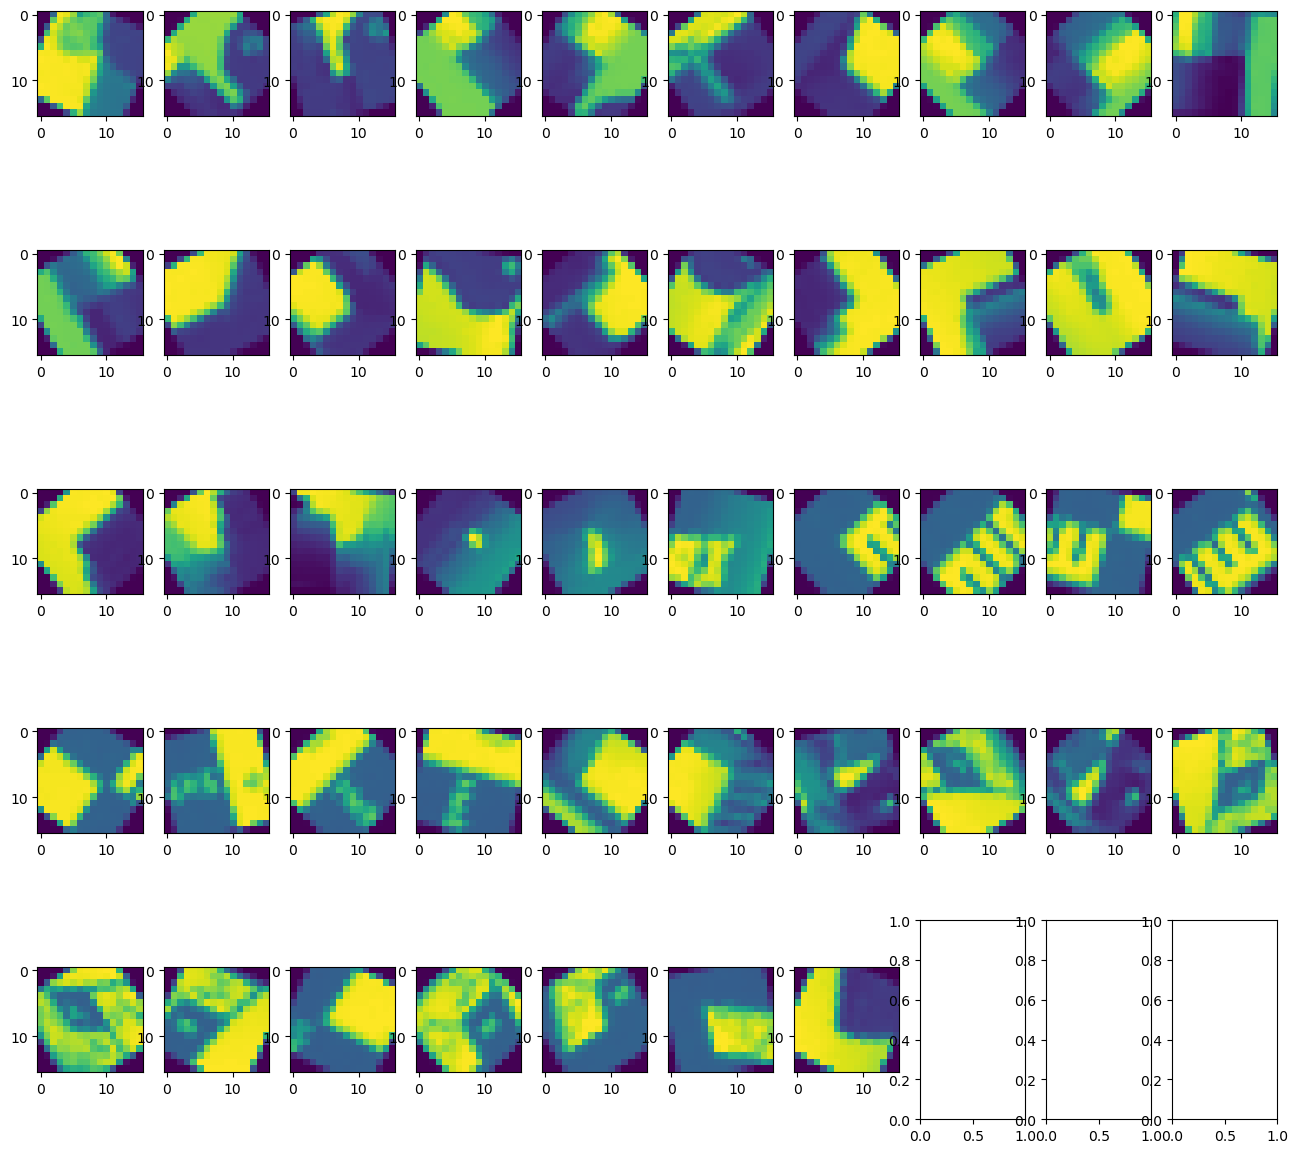

In [11]:
plot_patch_crops(patches_view2)

If you analyze the extracted patches from both views you should notice that some of them already look quite similar to patches from the other view. Now, we will construct a feature descriptor from them.

### 1.3. Computing the Feature Descriptor

There are different options to utilize the patch information and transform them into a feature representation. An intuitive approach is to compare the images by their color or color histograms. Yet, this reduces the robustness of our method to changes in lighting. Instead, we use image gradients as motivated in the [SIFT](https://link.springer.com/article/10.1023/B:VISI.0000029664.99615.94) paper and in the lecture.

To implement this descriptor you may reuse most of your code from the `extract_patches` method in the previous section. You again extract patches but this time not from the grayscale image but from the gradient images, i. e., the gradient image in $x$ and $y$ direction. Afterwards, you compute the gradient length and orientation for every pixel in the patch. The gradient magnitudes are weighted by a gaussian kernel of the same size as the patch and $\sigma=0.5 \cdot patch size$. Finally, the patch is separated into a 4x4 grid where each cell consists of an 4x4 pixels subpatch. For each of these subpatches an 8-bin histogram is computed over the orientations of the gradients in that cell. For example, all gradients with orientation between 0 - 45 degrees are counted in the first histogram bin. All gradients with orientation between 45-90 in the second and so on. Instead of increasing the counter by one for each gradient, we increase it by the weighted magnitude. In total, we have eight counts per cell and 16 cells in total which results in a 128-dimenstional feature vector which we will use to describe the keypoint. In the end, this feature vector shall be nomalized to unit length.

Hint: For histogram binning you can use `np.histogram` which already provides you with weighted bin counting.

In [12]:
from scipy.stats import multivariate_normal


# you may use this function to get the gaussian weights to weight the gradient magnitudes
def get_gaussian_weights(std, size):
    mvn = multivariate_normal(mean=[0,0], cov=[[std,0.],[0., std]])
    xs = np.arange((1 - size) / 2, (size + 1) / 2)
    xs, ys = np.meshgrid(xs,xs)
    pos = np.dstack((xs, ys))
    return mvn.pdf(pos)

def get_gradient_orientations(grad_patches_x: npt.ArrayLike, grad_patches_y: npt.ArrayLike) -> np.ndarray:
    """Compute the gradient orientation.

    :param grad_patches_x: gradient patch in x direction [number of keypoints, patch_size, patch_size]
    :param grad_patches_y: gradient patch in y direction [number of keypoints, patch_size, patch_size]
    :return array with the gradient orientations [number of keypoints, patch_size, patch_size]
    """
    grad_orientations = np.zeros_like(grad_patches_x)
    for i in range(grad_patches_x.shape[0]):
        grad_orientations[i] = np.arctan2(grad_patches_x[i, :, :], grad_patches_y[i, :, :])
    return grad_orientations * 180 / np.pi
        

def get_gradient_magnitudes(grad_patches_x: npt.ArrayLike, grad_patches_y: npt.ArrayLike) -> np.ndarray:
    """Compute the gradient magnitudes.

    :param grad_patches_x: gradient patch in x direction [number of keypoints, patch_size, patch_size]
    :param grad_patches_y: gradient patch in y direction [number of keypoints, patch_size, patch_size]
    :return array with the gradient magnitudes [number of keypoints, patch_size, patch_size]
    """
    return np.sqrt(grad_patches_x**2 + grad_patches_y**2)

def add_magnitude_weighting(magnitudes: npt.ArrayLike, patch_size: int):
    """Add weighting for the magnitudes (with get_gaussian_weights() function).

    :param magnitudes: gradient magnitudes [number of keypoints, patch_size, patch_size]
    :param patch_size: patch size
    :return array with weighted magnitudes [number of keypoints, patch_size, patch_size]
    """
    weights = get_gaussian_weights(0.5 * patch_size, patch_size)
    return magnitudes * weights

def create_features(keypoints: npt.ArrayLike, magnitudes: npt.ArrayLike, orientations: npt.ArrayLike, patch_size: int, cell_size: int, histogram_bins: int) -> np.ndarray:
    """Create feature vectors.

    :param keypoints: keypoint coordinates
    :param magnitudes: magnitudes
    :param orientations: orientations
    :param patch_size: patch size
    :param cell_size: cell size
    :param histogram_bins: histogram_bins
    :return array with feature vectors [number of keypoints, feature vector size]
    """
    feature_vectors = np.zeros((len(keypoints), (patch_size // cell_size)**2 * histogram_bins))

    for i in range(len(keypoints)):
        for j in range(patch_size // cell_size):
            for k in range(patch_size // cell_size):
                hist = np.histogram(orientations[i, j*cell_size:(j+1)*cell_size, k*cell_size:(k+1)*cell_size], bins=histogram_bins, weights=magnitudes[i, j*cell_size:(j+1)*cell_size, k*cell_size:(k+1)*cell_size])[0]
                feature_vectors[i, j*(patch_size // cell_size)*histogram_bins + k*histogram_bins : j*(patch_size // cell_size)*histogram_bins + (k+1)*histogram_bins] = hist

    return feature_vectors

def create_descriptors(img, keypoints, angles, patch_size=16, cell_size=4, histogram_bins=8):
    """
    This function creates descriptors from oriented patches around each key point
    :param img: the input image
    :param keypoints: the extracted keypoints
    :param angles: the orientation of the keypoints
    :param patch_size: the pixel length of each patch in x,y directions
    :param cell_size: the size of each gradient histogram cell
    :param histogram_bins: the number of bins per histogram
    :return: a 2D Numpy array containing all feature descriptors. The first dimension
             is the number of key points/patches. The second and third is 'patch_size'.
             
    """
    
    assert patch_size % cell_size == 0, "patch_size must be evenly divisible by cell_size"
    
    # 1. first convert to grayscale
    monochrome_img = to_grayscale(img)

    # 2. compute image gradients in x and y direction
    smoothed_img = gaussian_filter(monochrome_img, sigma=1)
    Ix, Iy = sobel(smoothed_img, axis=1), sobel(smoothed_img, axis=0)
    
    # 3. compute gradient patches
    grad_patches_x = extract_patches(Ix, keypoints, angles, patch_size)
    grad_patches_y = extract_patches(Iy, keypoints, angles, patch_size)
    
    # 4. compute gradient orientation and magnitude for each pixel in each patch (implement the functions above and call them)
    orientations = get_gradient_orientations(grad_patches_x, grad_patches_y)
    magnitudes = get_gradient_magnitudes(grad_patches_x, grad_patches_y)
    
    # 5. magnitude weighting (implement the function above and call it)
    weighted_magnitudes = add_magnitude_weighting(magnitudes, patch_size)
    
    # 6. create features (implement the function above and call it)
    features = create_features(keypoints, weighted_magnitudes, orientations, patch_size, cell_size, histogram_bins)
    
    # 7. return features
    return features

In [13]:
features = {}
features["view1"] = create_descriptors(view1, *keypoints['view1'], patch_size=16, cell_size=4)
features["view2"] = create_descriptors(view2, *keypoints['view2'], patch_size=16, cell_size=4)

In [14]:
features["view1"].shape# 47 keypoints, 16*8=128

(47, 128)

## 2. Feature Matching

Now that we have found image key points and assigned them a (hopefully) unique descriptor, it is time to find corresponding points in both images. There are sophisticated matching algorithms which avoid checking every key point from one view with the one from another view. However, for the sake of this exercise comparing all key points is our way to go. As we encoded the appearance of each key point by a feature vector, we can easily compute its sum of squared differences to all other feature vectors.

Hence, your first task is to compute the sum of squared differences between all key points in both views.
The result should be a matrix $D$ where $d_{ij} = \| f_i-f_j\|_2^2$ and $f_i, f_j$ are the feature vectors from key points i and j. Note that key points i come from view 1 and key points j from view 2.

$D$ can be displayed by matplotlib which shows you how close the points are to others.

In [15]:
type(features["view1"])

numpy.ndarray

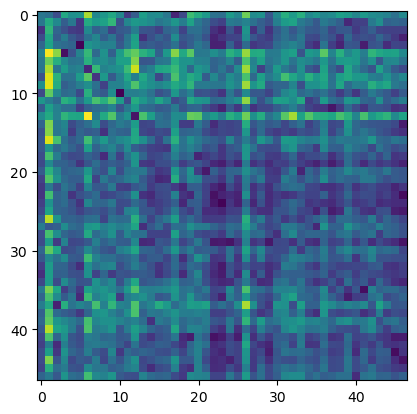

In [ ]:
features_view1 = features["view1"]
features_view2 = features["view2"]

def get_distances(features_view1: npt.ArrayLike, features_view2: npt.ArrayLike) -> np.ndarray:
    """Compute the distance matrix between the feature vectors.

    :param features_view1: feature vectors of view 1 [number of keypoints view 1, feature vector size]
    :param features_view2: feature vectors of view 2 [number of keypoints view 2, feature vector size]
    :return array with distance matrix [number of keypoints 1, number of keypoints view 2]
    """
    # TODO: implement it
    f1 = np.asarray(features_view1)
    f2 = np.asarray(features_view2)

    # More Efficient Implementation
    # f1_sq = np.sum(f1**2, axis=1).reshape(-1, 1)   # shape (N, 1)
    # f2_sq = np.sum(f2**2, axis=1).reshape(1, -1)   # shape (1, M)
    # cross_term = np.dot(f1, f2.T)                  # shape (N, M)
    # # Squared Euclidean distance
    # dists_squared = f1_sq + f2_sq - 2 * cross_term

    # Naive/ brute force implementation
    N, M = f1.shape[0], f2.shape[0]
    dists_squared = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            diff = f1[i] - f2[j]
            dists_squared[i, j] = np.sum(diff**2)
    return dists_squared


D = get_distances(features_view1, features_view2)  # TODO: implement and call get_distances

plt.imshow(D)
plt.show()

We see that there is a lot of ambiguity for some points. Hence, it may not be enough to choose the best pair of points but only pairs where the second best match is significantly worse. A simple method to do so is a ratio test. We check if the ratio between the shortest distance $d_1$ of the best match and the distance $d_2$ of the second best match is smaller than some threshold $T$. If so, we return the matched pair otherwise no match is returned.

Using this as a check, you can implement a simple matching function. You can verify the outputs by using the visualization function provided below. The function you are about to implement should also return the distance of the points in each match. You may sort the list of matches to see the best ones on top.

Hint: Only because key point P1 from view1 matches best with P2 from view2 doesn't mean P2 matches best with P1. The matching relation is not symmetric. So, key points might be used in different matches.

In [25]:
from matplotlib.patches import ConnectionPatch

# use this function to visualize the matches
def plot_matches(img1, img2, keypoints1, keypoints2, matches):
    fig, axes = plt.subplots(1,2,figsize=(16,7))
    
    # draw images
    axes[0].imshow(img1)
    axes[1].imshow(img2)
    
    # draw matches
    for index_1, index_2 in matches:
        kp1, kp2 = keypoints1[index_1], keypoints2[index_2]
        con = ConnectionPatch(xyA=kp1, coordsA=axes[0].transData,
                              xyB=kp2, coordsB=axes[1].transData, color='r')
        fig.add_artist(con)
        axes[0].plot(*kp1, color='r', marker='x')
        axes[1].plot(*kp2, color='r', marker='x')
    
    plt.show()
    

In [26]:
a=np.array([[1,2,3],[4,55,6]])
a[1]

array([ 4, 55,  6])

In [27]:
np.argsort(a[1])

array([0, 2, 1])

In [28]:
def get_matches(distances: npt.ArrayLike, threshold: float) -> np.ndarray:
    """Get matching keypoints.

    :param distances: the keypoint feature vector distance matrix [number of keypoints view 1, feature vector size]
    :param threshold: distance < threshold -> match candidate 
    :return array with matches, array with distances of the matches
    """
    # TODO: implement it
    # i think the distances would be of the shape [num of keypoints view1, num of keypoints view 2], what is mentioned above is incorrect
    matches, match_dist= [],[]
    num_keypt_view1=distances.shape[0]
    for i in range(0, num_keypt_view1):
        sorted_idx=np.argsort(distances[i])
        best_idx = sorted_idx[0]
        second_best_idx = sorted_idx[1]
        # calculating the best and second best distance
        closest_dist = distances[i,best_idx]
        second_closest_dist = distances[i,second_best_idx]
        # ratio test
        if (closest_dist / second_closest_dist + 1e-9) < threshold:
            matches.append([i, best_idx])
            match_dist.append(closest_dist)
    return np.array(matches), np.array(match_dist)


def remove_duplicate_matches(matches: npt.ArrayLike, match_distances: npt.ArrayLike) -> np.ndarray:
    """Remove duplicate matches.

    :param matches: matched keypoints
    :param match_distances: distances between matched keypoints
    :return array with distinct matches, array with corresponding distances of the distinct matches
    """
    unique_matches = {}
    for idx, (m, dist) in enumerate(zip(matches, match_distances)):
        k1, k2 = m
        if k2 not in unique_matches or dist < unique_matches[k2][1]:
            unique_matches[k2] = (idx, dist)

    filtered_indices = [val[0] for val in unique_matches.values()]
    return matches[filtered_indices], match_distances[filtered_indices]

def match_keypoints(features_view1, features_view2, threshold=0.7):
    """
    :param features_view1: a 2D numpy array containing the feature vectors for each keypoint in view 1
    :param features_view2: a 2D numpy array containing the feature vectors for each keypoint in view 2
    :param threshold: the ratio threshold
    :return: Two arrays are returned. First, a 2D numpy array where each row 
             consists of two indices forming a match. The first index corresponds 
             to to the row number in features_view1 and the second to 
             the row number in features_view2. The second array is the distance between
             the points of a match.
    """
    # 1. compute distances
    # TODO: implement it
    D = get_distances(features_view1=features_view1,
                        features_view2=features_view2)
    
    # 2. retrieve best matches for key points from view 1 and 2 and perform ratio checks 
    # TODO: implement the function get_matches above and call it
    matches, match_distances = get_matches(D, threshold)
    
    # 3. remove duplicates
    # TODO: implement the function remove_duplicate_matches above and call it
    matches, match_distances =  remove_duplicate_matches(matches,         match_distances)
    
    # 4. return all matches between both views and their distances
    return matches, match_distances

In [29]:
# a=np.array([[0,2],[1,4],[2,6],[3,8]])
# b=np.array([1,2,0.3,1.5])

# sorted_idx_check = np.argsort(b)
# print(sorted_idx_check)
# print(a[sorted_idx_check])

top-6 matches are:
 [[37  2]
 [24 23]
 [ 4  5]
 [ 5  3]
 [13 12]
 [43 45]]


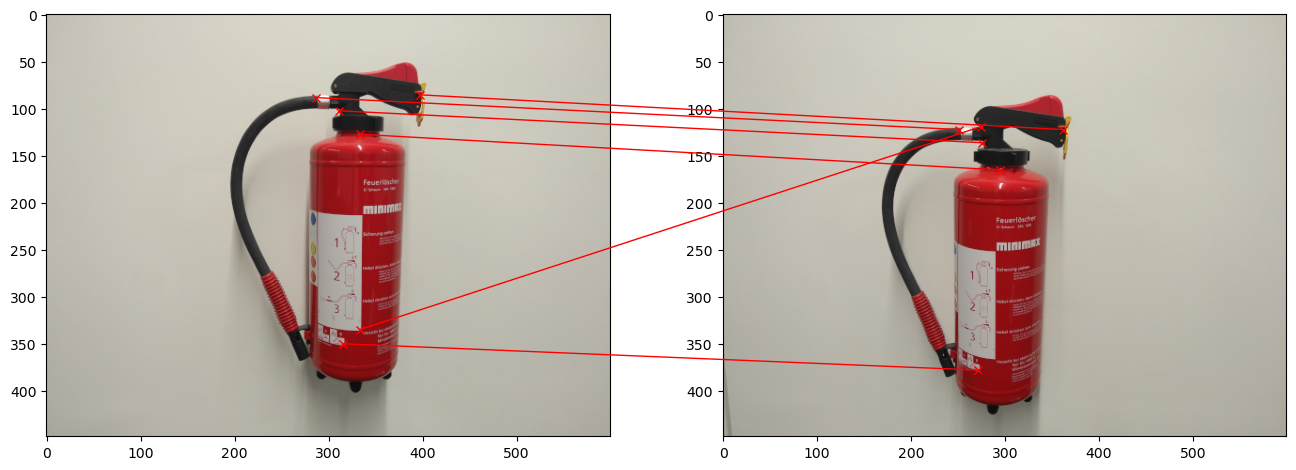

In [31]:
matches, match_distances = match_keypoints(features["view1"], features["view2"])

# sort matches by distance
sorted_indices = np.argsort(match_distances)
sorted_matches = matches[-sorted_indices]
sorted_distances = match_distances[-sorted_indices]

# choose k best matches
k = 6# TODO: implement it
top_k_matches = sorted_matches[:k] # TODO: implement it
print(f"top-{k} matches are:\n", top_k_matches)

# # visualize
plot_matches(view1, view2, keypoints["view1"][0], keypoints["view2"][0], top_k_matches)